In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mbti_1.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_model = SentimentIntensityAnalyzer()
import spacy
from sklearn import metrics
nlp = spacy.load('en')

import re
from collections import Counter

In [3]:
df = pd.read_csv("../input/mbti_1.csv")
posts = df['posts'].values.tolist()
types = df['type'].values.tolist()
print(len(posts),len(types))

8675 8675


In [4]:
# Preprocess data:

## Replace post separator ||| with semi-colon ;
df['posts'] = df['posts'].replace(to_replace = r'\|\|\|', value = r';',regex=True)

## Replace all http links with 'url'
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url'
df['posts'] = df['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)

## Remove Personality Type Words - to ensure the validity of the estimation for unseen instances
pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
p = re.compile("(" + "|".join(pers_types) + ")")
df['posts'] = df['posts'].replace(to_replace = p, value = r'PTypeToken', regex = True)

In [5]:
print(df.head())
print(df.tail())

   type                                              posts
0  INFJ  'url and intj moments  url  sportscenter not t...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   url course, to which I say ...
3  INTJ  'Dear PTypeToken,   I enjoyed our conversation...
4  ENTJ  'You're fired.;That's another silly misconcept...
      type                                              posts
8670  ISFP  'url just because I always think of cats as Fi...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...


In [6]:
total_dict = {}
for i in range(len(posts)):
    total_dict[i] = [types[i],posts[i]]

In [7]:
print('Personality types and their frequencies:')
types = df.groupby('type').count()
types.sort_values("posts", ascending=False, inplace=True)
print(types)

Personality types and their frequencies:
      posts
type       
INFP   1832
INFJ   1470
INTP   1304
INTJ   1091
ENTP    685
ENFP    675
ISTP    337
ISFP    271
ENTJ    231
ISTJ    205
ENFJ    190
ISFJ    166
ESTP     89
ESFP     48
ESFJ     42
ESTJ     39


In [8]:
#Function that counts the number of parts of speech
def bag_of_words(group, type_label):
    posts = [t for t in group.get_group(type_label)['posts']]
    nlp = spacy.load('en_core_web_sm')
    count_tags = Counter()
    for posts_per_user in posts:
        doc = nlp(str(posts_per_user))
        count_tags.update(Counter([token.pos_ for token in doc]))
    return count_tags

In [11]:
def replace_nth_string(string, old, new, n):
    num=0
    start=-1
    while num<n:
        start=string.find(old, start+1)
        if start == -1:return -1
        num+=1
    positioned_string = start
    if n == -1:
        return string
    return string[:positioned_string]+new+string[positioned_string+len(old):]

In [12]:
#Remove 'like' that is not a verb
def pos_sentence(message):
    sen_array = nltk.word_tokenize(message)
    tagged = nltk.pos_tag(sen_array)
    i = 0
    indx = []
    for x,y in tagged:
        if x == 'like':
            i += 1
            if y != 'VB':
                indx.append(i)
    new_msg = message
    for i in indx:
        new_msg = replace_nth_string(message, 'like', '', i)
    return new_msg

In [13]:
from IPython.display import clear_output

In [14]:
pos_feature = []
entity_feature =[]
len_posts = []
i = 0
for posts_per_user in df['posts']:
    clear_output(wait=True)
    doc = nlp(posts_per_user)
    count_tags = Counter([token.pos_ for token in doc])
    count_labels = Counter([token.label_ for token in doc.ents])
    pos_feature.append(count_tags)
    entity_feature.append(count_labels)
    len_posts.append({'length': len(posts_per_user)})
    print("Current progress: ", i)
    i+=1

Current progress:  8674


In [15]:
def run_vader(textual_unit, 
              lemmatize=False, 
              parts_of_speech_to_consider=set(),
              verbose=0):
    """
    Run VADER on a sentence from spacy
    
    :param str textual unit: a textual unit, e.g., sentence, sentences (one string)
    (by looping over doc.sents)
    :param bool lemmatize: If True, provide lemmas to VADER instead of words
    :param set parts_of_speech_to_consider:
    -empty set -> all parts of speech are provided
    -non-empty set: only these parts of speech are considered
    :param int verbose: if set to 1, information is printed
    about input and output
    
    :rtype: dict
    :return: vader output dict
    """
    doc = nlp(textual_unit)
        
    input_to_vader = []

    for sent in doc.sents:
        for token in sent:

            to_add = token.text

            if lemmatize:
                to_add = token.lemma_

                if to_add == '-PRON-': 
                    to_add = token.text

            if parts_of_speech_to_consider:
                if token.pos_ in parts_of_speech_to_consider:
                    input_to_vader.append(to_add) 
            else:
                input_to_vader.append(to_add)

    scores = vader_model.polarity_scores(' '.join(input_to_vader))
    
    if verbose >= 1:
        print()
        print('INPUT SENTENCE', sent)
        print('INPUT TO VADER', input_to_vader)
        print('VADER OUTPUT', scores)

    return scores

In [17]:
def vader_output_to_label(vader_output):
    """
    map vader output e.g.,
    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
    to one of the following values:
    a) positive float -> 'positive'
    b) 0.0 -> 'neutral'
    c) negative float -> 'negative'
    
    :param dict vader_output: output dict from vader
    
    :rtype: str
    :return: 'negative' | 'neutral' | 'positive'
    """
    compound = vader_output['compound']
    negative = vader_output['neg']
    positive = vader_output['pos']
    neutral = vader_output['neu']
    
    minimum = 2
    to_return = "positive"
    if abs(compound-positive) < minimum:
        minimum = compound-positive
        to_return = 'positive'
    if abs(compound-negative) < minimum:
        minimum = compound-negative
        to_return = 'negative'
    if abs(compound-neutral) < minimum:
        minimum = compound-neutral
        to_return = 'neutral'
    return to_return
    


In [18]:
messages = []
all_vader_output = []
original = {} #wait for mai to convert csv to readable dict
all_id_vader = {}
vader_dict = {'INFP': 0, 'INFJ': 0, 'INTP': 0, 'INTJ': 0, 'ENTP': 0, 'ENFP': 0,\
             'ISTP': 0, 'ISFP': 0, 'ENTJ': 0, 'ISFJ': 0, 'ESTP': 0, 'ESFP': 0,\
             'ESFJ': 0, 'ESFJ': 0, 'ESTJ': 0, 'ISTJ': 0, 'ENFJ': 0,} #add here all the keys/characters

for id_, val_arr in total_dict.items():
    clear_output(wait=True)
    message = val_arr[1]
    new_msg = pos_sentence(message)
    vader_output = run_vader(new_msg)
    vader_label =  vader_output_to_label(vader_output)
    #all_id_vader.append{id:vadel_label}
    messages.append(message)
    all_vader_output.append({'sen': vader_label})
    
    if vader_label == "negative":
        vader_dict[val_arr[0]] -= 1
    if vader_label == "positive":
        vader_dict[val_arr[0]] += 1
    #if neutral, do nothing
    print("Current progress: ", id_)
    
for character, score in vader_dict.items():
    if score < 0:
        print(character, " has a mean negative sentiment.")
    if score == 0:
        print(character, " has a mean neutral sentiment.")
    if score > 0:
        print(character, " has a mean positive sentiment.")

Current progress:  8674
INFP  has a mean positive sentiment.
INFJ  has a mean positive sentiment.
INTP  has a mean positive sentiment.
INTJ  has a mean positive sentiment.
ENTP  has a mean positive sentiment.
ENFP  has a mean positive sentiment.
ISTP  has a mean positive sentiment.
ISFP  has a mean positive sentiment.
ENTJ  has a mean positive sentiment.
ISFJ  has a mean positive sentiment.
ESTP  has a mean positive sentiment.
ESFP  has a mean positive sentiment.
ESFJ  has a mean positive sentiment.
ESTJ  has a mean positive sentiment.
ISTJ  has a mean positive sentiment.
ENFJ  has a mean positive sentiment.


In [23]:
types = df.groupby('type').count()
posts = types["posts"]
for i,j in vader_dict.items():
    if j/posts[i] < 0.07:
        print(i, ' neutral')
    else:
        print(i, 'positive')

INFP  neutral
INFJ  neutral
INTP positive
INTJ positive
ENTP positive
ENFP  neutral
ISTP positive
ISFP  neutral
ENTJ  neutral
ISFJ  neutral
ESTP  neutral
ESFP positive
ESFJ  neutral
ESTJ positive
ISTJ  neutral
ENFJ  neutral


In [24]:
i = 0
arr_neg = []
for j in all_vader_output:
    if j['sen'] == 'negative':
        arr_neg.append(i)
    i+=1

key = list(total_dict.values())

types_neg = []
for i in arr_neg:
    types_neg.append(key[i][0])

i = 0
arr_pos = []
for j in all_vader_output:
    if j['sen'] == 'positive':
        arr_pos.append(i)
    i+=1

types_pos = []
for i in arr_pos:
    types_pos.append(key[i][0])

i = 0
arr_neu = []
for j in all_vader_output:
    if j['sen'] == 'neutral':
        arr_neu.append(i)
    i+=1

types_neu = []
for i in arr_neu:
    types_neu.append(key[i][0])

print('negative: ', Counter(types_neg))
print('positive: ', Counter(types_pos))
print('neutral: ', Counter(types_neu))


negative:  Counter({'INTJ': 2, 'ISTJ': 1, 'ENTP': 1, 'ENTJ': 1, 'INTP': 1})
positive:  Counter({'INTP': 124, 'INFP': 108, 'INTJ': 97, 'ENTP': 55, 'INFJ': 47, 'ISTP': 35, 'ENTJ': 14, 'ENFP': 12, 'ISTJ': 12, 'ISFP': 11, 'ISFJ': 7, 'ESTP': 5, 'ESTJ': 5, 'ESFP': 4, 'ENFJ': 4, 'ESFJ': 2})
neutral:  Counter({'INFP': 1724, 'INFJ': 1423, 'INTP': 1179, 'INTJ': 992, 'ENFP': 663, 'ENTP': 629, 'ISTP': 302, 'ISFP': 260, 'ENTJ': 216, 'ISTJ': 192, 'ENFJ': 186, 'ISFJ': 159, 'ESTP': 84, 'ESFP': 44, 'ESFJ': 40, 'ESTJ': 34})


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

In [26]:
# Combine all features into a list of dicts of features
features = [dict(**a,**b,**c,**d) for a,b,c,d in zip(pos_feature,len_posts,all_vader_output,entity_feature)]
# Extract labels
labels = df['type']
# Vectorize features
vec = DictVectorizer()
new_features = vec.fit_transform(features).toarray()

In [27]:
new_features.shape

(8675, 39)

In [29]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

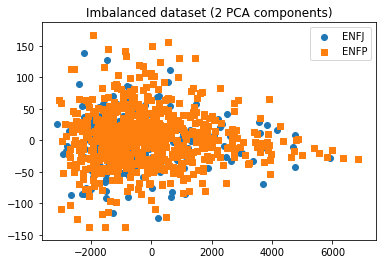

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(new_features)

plot_2d_space(X, labels, 'Imbalanced dataset (2 PCA components)')

Using TensorFlow backend.


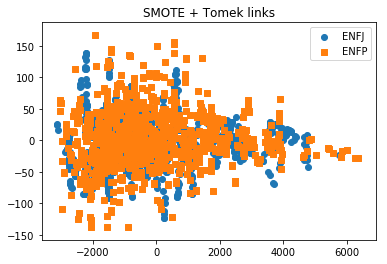

In [31]:
#Fix the imbalance of the dataset
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, labels)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [32]:
# Split data into training and test
posts_train, posts_test, type_train, type_test = train_test_split(
    X_smt,
    y_smt, 
    test_size = 0.20, # we use 80% for training and 20% for development
    random_state = 123
    ) 

In [33]:
lin_clf = svm.LinearSVC(dual=False)
lin_clf.fit(posts_train,type_train)
predicted_labels = lin_clf.predict(posts_test)

In [34]:
report = metrics.classification_report(y_true=type_test,y_pred=predicted_labels)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
print('balanced dataset: ')
print(report)

balanced dataset: 
              precision    recall  f1-score   support

        ENFJ       0.09      0.28      0.14       242
        ENFP       0.00      0.00      0.00       225
        ENTJ       0.03      0.00      0.01       243
        ENTP       0.00      0.00      0.00       273
        ESFJ       0.08      0.29      0.12       270
        ESFP       0.09      0.53      0.15       260
        ESTJ       0.10      0.19      0.13       265
        ESTP       0.00      0.00      0.00       239
        INFJ       0.00      0.00      0.00       218
        INFP       0.00      0.00      0.00       188
        INTJ       0.00      0.00      0.00       234
        INTP       0.00      0.00      0.00       223
        ISFJ       0.00      0.00      0.00       247
        ISFP       0.00      0.00      0.00       231
        ISTJ       0.00      0.00      0.00       269
        ISTP       0.00      0.00      0.00       244

   micro avg       0.09      0.09      0.09      3871
   macr

In [ ]:
# Split data into training and test
posts_train, posts_test, type_train, type_test = train_test_split(
    new_features,
    labels, 
    test_size = 0.20, 
    random_state = 123
    ) 

In [ ]:
lin_clf = svm.LinearSVC(dual=False)
lin_clf.fit(posts_train,type_train)
predicted_labels = lin_clf.predict(posts_test)

In [ ]:
report = metrics.classification_report(y_true=type_test,y_pred=predicted_labels)

In [ ]:
print('unbalanced dataset: ')
print(report)